In [46]:
import os
import sys
import random
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
sys.path.append('./Mask_RCNN')
from Mask_RCNN import utils
from Mask_RCNN import model as modellib
from Sixd import SixdConfig, SixdDataset
import visualize

class InferenceConfig(SixdConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
#file_dir = os.path.dirname(os.path.abspath(__file__))
#project_dir = os.path.dirname(file_dir)

dataset_coco_dir = '../datasets/coco'
dataset_sixd_dir = '../datasets/sixd/doumanoglou/train'

COCO_MODEL_PATH = 'Mask_RCNN/mask_rcnn_coco.h5'
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

config = SixdConfig()

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [47]:
dataset_train = SixdDataset()
dataset_train.load_sixd(3000, dataset_coco_dir, 'train', dataset_sixd_dir)
dataset_train.prepare()

dataset_val = SixdDataset()
dataset_val.load_sixd(250, dataset_coco_dir, 'val', dataset_sixd_dir)
dataset_val.prepare()

inference_config = InferenceConfig()
# Recreate the model in inference mode
with tf.device("/cpu:0"):
    model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir='logs')

Using cached definition file: image_def_train2017_3000.yaml
Using cached definition file: image_def_val2017_250.yaml


In [48]:
# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = model.find_last()[1]
#model_path = 'logs/sixd20180406T1447/mask_rcnn_sixd_0001.h5'

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  logs/sixd20180406T1527/mask_rcnn_sixd_0014.h5


original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max:  640.00000  float64
gt_class_id              shape: (11,)                 min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (11, 4)               min:    0.00000  max:  507.00000  int32
gt_mask                  shape: (512, 512, 11)        min:    0.00000  max:    1.00000  bool


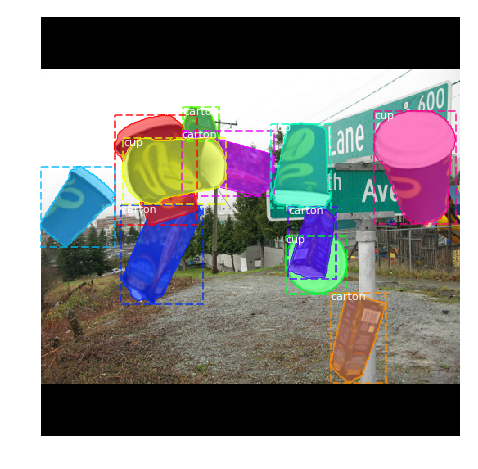

In [49]:
# Test on a random image

from model import log
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  640.00000  float64


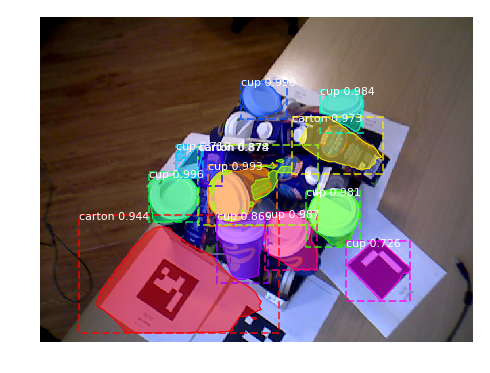

In [50]:
from PIL import Image
import numpy as np
original_image = Image.open('../datasets/sixd/doumanoglou/test/03/rgb/0055.png')
original_image = np.array(original_image)
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [51]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.8939838455732051
